# Use Paddle Quantum to train a PQC

_Copyright (c) 2023 Institute for Quantum Computing, Baidu Inc. All Rights Reserved._

Variational Quantum Algorithms (VQA) refers to algorithms that solve specific problems by training a parameterized quantum circuit (PQC) using a classical optimizer. It can be seen as a natural analogy of machine learning in quantum computing. Therefore, a PQC is also referred to as a quantum neural network (QNN).

Paddle Quantum provides a comprehensive and easy-to-use toolkit for training PQCs. Using Paddle Quantum, we take quantum state preparation as an example to introduce how to conveniently build a PQC, set parameters, and train the PQC using a classical optimizer.

## Construct a QNN

Using the Circuit class in Paddle Quantum, we can construct a QNN by composing various quantum gates. Let's take a concrete example below.

In [9]:
# import packages
import numpy as np
import paddle
from paddle_quantum.ansatz import Circuit
from paddle_quantum.state import ghz_state
from paddle_quantum.loss import StateFidelity
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [10]:
# construct a blank quantum circuit on 4 qubits
cir_1 = Circuit(4)

# add a layer of Ry, Rx and CNOT gates
cir_1.ry()    # default：qubits_idx='full'，i.e., add such a single-qubit quantum gate to all qubits. The training parameters are initialized randomly
cir_1.rx()
cir_1.cnot()  # default：qubits_idx='cycle'，i.e., add such a two-qubit quantum gate to all pairs of neighboring qubits

# print the constructed circuit
print(cir_1)

--Ry(1.332)----Rx(5.582)----*--------------x--
                            |              |  
--Ry(6.031)----Rx(1.548)----x----*---------|--
                                 |         |  
--Ry(5.681)----Rx(4.597)---------x----*----|--
                                      |    |  
--Ry(4.998)----Rx(6.073)--------------x----*--
                                              


In the example above, quantum gates are added to all qubits by default in a layer-wise manner, which is a common method for constructing QNNs. Similar to classical neural networks, each layer of quantum gates can be referred to as a training layer. If we want to specify the qubits on which a certain quantum gate acts, we can simply change the qubits_idx parameter.

In [11]:
# construct a blank quantum circuit
cir_2 = Circuit(3)

# add quantum gates in a specific way
cir_2.ry(qubits_idx='even')           # add such a single-qubit quantum gate to all even-numbered qubits
cir_2.rx(qubits_idx=1)                # add quantum gates by specifying the qubit index
cir_2.cnot(qubits_idx=[[0,1],[2,1]])  # add quantum gates by specifying the qubit indices, where the former is the control qubit and the latter is the target qubit

# print the constructed circuit
print(cir_2)

--Ry(2.892)----*-------
               |       
--Rx(3.203)----x----x--
                    |  
--Ry(6.145)---------*--
                       


Paddle Quantum also provides built-in templates for common training layers, which make it easier for users to quickly construct QNNs. Other templates can be found in the [Paddle Quantum API](https://qml.baidu.com/api/paddle_quantum.ansatz.circuit.html).

In [12]:
# construct a blank quantum circuit
cir_3 = Circuit(4)

# add two layers of the built-in template real_entangled_layer: each layer contains a layer of Ry gates and a layer of CNOT gates
cir_3.real_entangled_layer(depth=2)
# add one layer of the built-in template complex_entangled_layer: each layer contains a layer of U3 gates and a layer of CNOT gates
cir_3.complex_entangled_layer(depth=1)

# print the constructed circuit
print(cir_3)

--Ry(5.156)----*--------------x----Ry(3.702)----*--------------x----U----*--------------x--
               |              |                 |              |         |              |  
--Ry(0.102)----x----*---------|----Ry(5.598)----x----*---------|----U----x----*---------|--
                    |         |                      |         |              |         |  
--Ry(4.582)---------x----*----|----Ry(0.862)---------x----*----|----U---------x----*----|--
                         |    |                           |    |                   |    |  
--Ry(3.816)--------------x----*----Ry(2.835)--------------x----*----U--------------x----*--
                                                                                           


## Set parameters in QNNs

In the above example, the parameters in the QNN are initialized randomly by default. We can retrieve the values of the existing parameters in the circuit and store them in an array by accessing the param property.

In [13]:
# construct a blank quantum circuit
cir_4 = Circuit(2)
# add a layer of Ry gates
cir_4.ry()
# print the constructed circuit
print(cir_4)
# print the values of the parameters in the circuit
print(cir_4.param)

--Ry(3.633)--
             
--Ry(4.663)--
             
Tensor(shape=[2], dtype=float32, place=Place(cpu), stop_gradient=False,
       [3.63321853, 4.66316223])


In addition, we can manually set the values of the parameters in the circuit by executing the update_param() method.

In [14]:
# create an array of new parameters
theta_new = paddle.to_tensor([0.1, 0.2], dtype='float32')
# update the parameters in the circuit
cir_4.update_param(theta_new)
# print the constructed circuit
print(cir_4)
# print the values of the parameters in the circuit
print(cir_4.param)

--Ry(0.100)--
             
--Ry(0.200)--
             
Tensor(shape=[2], dtype=float32, place=Place(cpu), stop_gradient=False,
       [0.10000000, 0.20000000])


## Use a classical optimizer to train a QNN

After constructing the QNN, we can define a loss function as needed and call the classical optimizer to train this QNN. Here we use QNNs to learn a GHZ state, and use the fidelity distance as the loss function.

In [15]:
# define the hyperparameters in the training
ITR = 100    # training iteration number
LR = 0.02    # learning rate

# define a PQC
cir = Circuit(4)
cir.ry()
cir.rx()
cir.cnot()

# define the form of the loss function. Here we use the fidelity distance between the output state from the circuit and the GHZ state
loss_func = StateFidelity(ghz_state(4))
# choose a classical optimizer, where we usually use Adam
opt = paddle.optimizer.Adam(learning_rate=LR, parameters=cir.parameters())
# create a list to record the training process
loss_list = []
# start iteration of optimization
for itr in range(ITR):
    # run the circuit, get the output state, compute the loss value
    loss = loss_func(cir())
    # backward propagating，compute the gradient
    loss.backward()
    # minimize the loss function, update the parameters
    opt.minimize(loss)
    opt.clear_grad()
    # record the loss value
    loss_list.append(loss.numpy().item())
    if itr % 5 == 0:
        print(f'iter: {itr},   loss: {loss.numpy().item():.4f}')

iter: 0,   loss: 0.0379
iter: 5,   loss: 0.0226
iter: 10,   loss: 0.0126
iter: 15,   loss: 0.0065
iter: 20,   loss: 0.0032
iter: 25,   loss: 0.0014
iter: 30,   loss: 0.0005
iter: 35,   loss: 0.0003
iter: 40,   loss: 0.0003
iter: 45,   loss: 0.0003
iter: 50,   loss: 0.0002
iter: 55,   loss: 0.0001
iter: 60,   loss: 0.0000
iter: 65,   loss: 0.0001
iter: 70,   loss: 0.0000
iter: 75,   loss: 0.0000
iter: 80,   loss: 0.0000
iter: 85,   loss: 0.0000
iter: 90,   loss: 0.0000
iter: 95,   loss: 0.0000


--Ry(5.709)----Rx(3.130)----*--------------x--
                            |              |  
--Ry(4.281)----Rx(0.462)----x----*---------|--
                                 |         |  
--Ry(3.437)----Rx(-0.01)---------x----*----|--
                                      |    |  
--Ry(0.000)----Rx(3.140)--------------x----*--
                                              


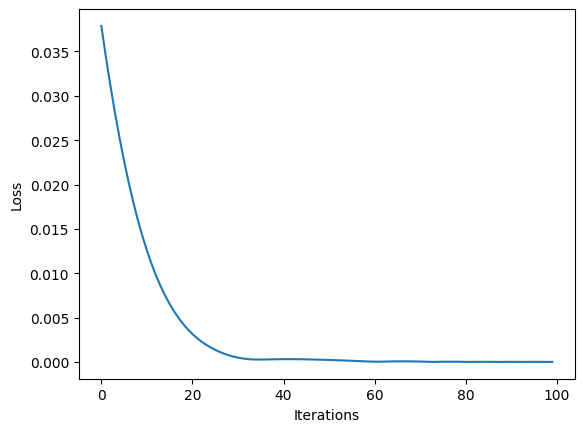

In [16]:
# output the PQC after training
print(cir)

# plot the loss value as a function of the iteration number
func = plt.plot(loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

We can find that the fidelity distance converges near zero as the training proceeds, which means that the output state of the PQC is very close to the target state, and hence we have successfully trained a quantum circuit that can prepare the target state.